In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

In [8]:
NUM_CLASSES = 40
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None, is_train=True):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            is_train (bool): Whether this is the training set or validation set
        """
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        
        # Get all subdirectories (disease categories)
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Get all image paths and their corresponding labels
        self.image_paths = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label



In [6]:
def get_transforms():
    # Training transforms with data augmentation
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Validation transforms
    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    return train_transform, val_transform

In [10]:
def create_model(num_classes=NUM_CLASSES, pretrained=True):
    if pretrained:
        model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    else:
        model = resnet50(weights=None)
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_accuracy = 0.0
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass + optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
        
        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())
        
        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += inputs.size(0)
            
            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples
            
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc.item())
            
            print(f'Epoch {epoch+1}/{num_epochs} - Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}')
            
            # Save the best model
            if epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')
                print(f'Model saved with accuracy: {best_accuracy:.4f}')
    
    # Plot training curves
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [12]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(train_losses, label='Training Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(train_accuracies, label='Training Accuracy')
    ax2.plot(val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()

In [13]:
def predict_disease(model, image_path, transform, class_names):
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        
        # Get probabilities
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        
    # Get top 3 predictions
    top3_prob, top3_indices = torch.topk(probabilities, 3)
    top3_prob = top3_prob.cpu().numpy()[0]
    top3_indices = top3_indices.cpu().numpy()[0]
    
    top3_predictions = [(class_names[idx], prob) for idx, prob in zip(top3_indices, top3_prob)]
    
    return top3_predictions

In [20]:
def main():
    # Get data transforms
    train_transform, val_transform = get_transforms()
    
    # Load datasets
    train_dataset = PlantDiseaseDataset(root_dir='../New Plant Diseases Dataset(Augmented)/train', 
                                       transform=train_transform, 
                                       is_train=True)
    
    val_dataset = PlantDiseaseDataset(root_dir='../New Plant Diseases Dataset(Augmented)/valid', 
                                     transform=val_transform, 
                                     is_train=False)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    # Get class names
    class_names = train_dataset.classes
    
    # Create model
    model = create_model(num_classes=NUM_CLASSES, pretrained=True)
    model = model.to(DEVICE)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    # Train the model
    model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS
    )
    
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    # Example of making a prediction
    # test_image_path = 'path/to/test_image.jpg'
    # top3_predictions = predict_disease(model, test_image_path, val_transform, class_names)
    
    # print("Top 3 predictions:")
    # for disease, prob in top3_predictions:
    #     print(f"{disease}: {prob:.4f}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/nishantk30/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.3MB/s]
/home/nishantk30/miniconda3/envs/torchenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 - Train Loss: 0.4640, Train Acc: 0.8553
Epoch 1/20 - Val Loss: 0.2859, Val Acc: 0.9098
Model saved with accuracy: 0.9098
Epoch 2/20 - Train Loss: 0.2795, Train Acc: 0.9019
Epoch 2/20 - Val Loss: 0.1923, Val Acc: 0.9316
Model saved with accuracy: 0.9316
Epoch 3/20 - Train Loss: 0.2510, Train Acc: 0.9097
Epoch 3/20 - Val Loss: 0.1263, Val Acc: 0.9549
Model saved with accuracy: 0.9549
Epoch 4/20 - Train Loss: 0.2243, Train Acc: 0.9170
Epoch 4/20 - Val Loss: 0.2671, Val Acc: 0.9182
Epoch 5/20 - Train Loss: 0.2152, Train Acc: 0.9162
Epoch 5/20 - Val Loss: 0.1637, Val Acc: 0.9382
Epoch 6/20 - Train Loss: 0.1732, Train Acc: 0.9362
Epoch 6/20 - Val Loss: 0.2005, Val Acc: 0.9416
Epoch 7/20 - Train Loss: 0.2011, Train Acc: 0.9285
Epoch 7/20 - Val Loss: 0.1159, Val Acc: 0.9633
Model saved with accuracy: 0.9633
Epoch 8/20 - Train Loss: 0.1880, Train Acc: 0.9399
Epoch 8/20 - Val Loss: 0.1295, Val Acc: 0.9466
Epoch 9/20 - Train Loss: 0.1597, Train Acc: 0.9444
Epoch 9/20 - Val Loss: 0.0945

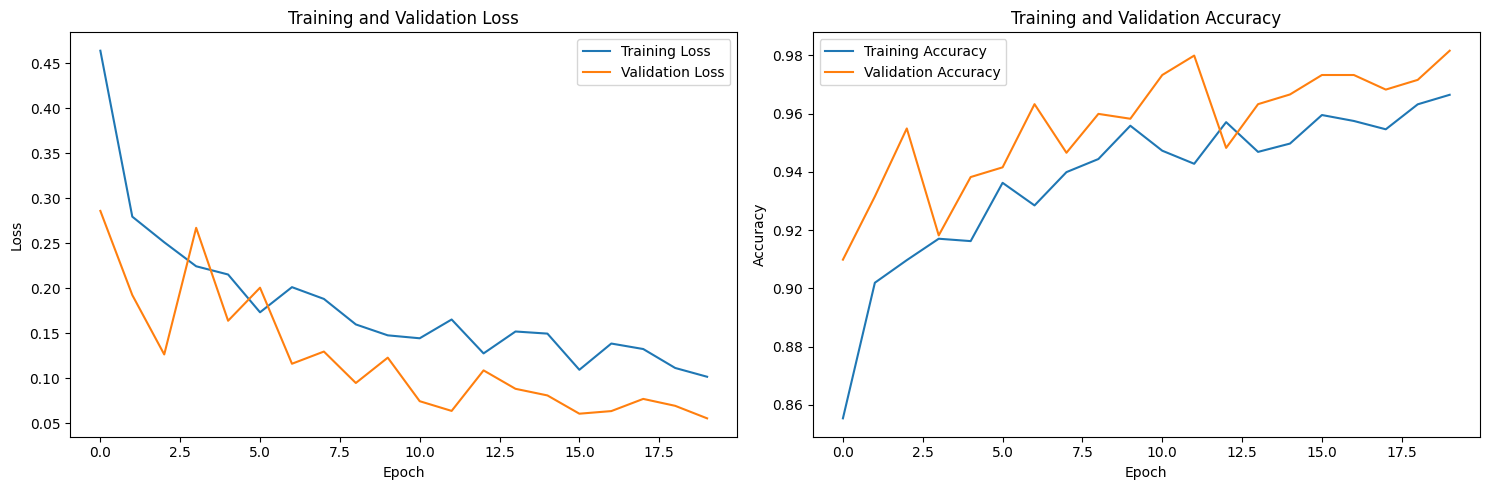

/tmp/ipykernel_4363/3527489138.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [21]:
if __name__ == "__main__":
    main()